In [1]:
import torch
import numpy as np
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from collections import Counter

SEED = 4213
random.seed(SEED)
np.random.seed(SEED)

# Load tokenised dataset from .pt file
data = torch.load("data/sarcasm_dataset.pt")
input_ids = data['input_ids']           # token IDs
attention_mask = data['attention_mask'] # mask for padding
labels = data['labels']                 # binary labels
texts = data.get('texts', None)         # original text (optional)

print("input_ids.shape:", input_ids.shape)
print("attention_mask.shape:", attention_mask.shape)
print("labels.shape:", labels.shape)
if texts is not None:
    print("sample text:", texts[0])


#Convert into subword tokens
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def ids_to_subword_doc(ids_row, attn_row, tokenizer, remove_special=True):
    tokens = tokenizer.convert_ids_to_tokens(ids_row.tolist())
    if remove_special:
        tokens_filtered = []
        for t, m in zip(tokens, attn_row.tolist()):
            if m == 0:
                break  # stop at padding
            if t in tokenizer.all_special_tokens:
                continue
            tokens_filtered.append(t)
        return " ".join(tokens_filtered)
    else:
        return " ".join(tokens)

# Convert all rows
docs = []
for i in tqdm(range(input_ids.shape[0]), desc="Converting tokens"):
    docs.append(ids_to_subword_doc(input_ids[i], attention_mask[i], tokenizer))

# Extract TF-IDF features from subword tokens
vectorizer = TfidfVectorizer(
    lowercase=False,      
    tokenizer=None,
    token_pattern=r"(?u)\S+",  # treat whitespace-separated tokens as tokens
    min_df=3,              # drop very rare subwords
    max_df=0.95,           # drop extremely common tokens
    ngram_range=(1,2)      # allow subword bigrams too
)
X = vectorizer.fit_transform(docs)  
y = np.array(labels).astype(int).ravel()

print("TF-IDF matrix shape:", X.shape)

#Verify reconstruction
for i in range(5):  # or any sample size
    print(f"Label: {y[i]}")
    print(f"Subword doc: {docs[i]}")
    if texts is not None:
        print(f"Original text: {texts[i]}")
    print("-" * 40)


# Split data into 80-10-10 train-val-test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)
print("Sizes: train, val, test =", X_train.shape[0], X_val.shape[0], X_test.shape[0])

def report_class_distribution(y, name):
    counter = Counter(y)
    total = sum(counter.values())
    print(f"{name} set:")
    for label, count in sorted(counter.items()):
        percent = count / total * 100
        print(f"  Class {label}: {count} samples ({percent:.2f}%)")
    print()

report_class_distribution(y_train, "Train")
report_class_distribution(y_val, "Validation")
report_class_distribution(y_test, "Test")


C:\Users\angsp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


input_ids.shape: torch.Size([1126324, 128])
attention_mask.shape: torch.Size([1126324, 128])
labels.shape: torch.Size([1126324])
sample text: nc and nh.


Converting tokens: 100%|██████████| 1126324/1126324 [01:18<00:00, 14382.31it/s]


TF-IDF matrix shape: (1126324, 558304)
Label: 0
Subword doc: nc and nh .
Original text: nc and nh.
----------------------------------------
Label: 0
Subword doc: you do know west teams play against west teams more than east teams right ?
Original text: you do know west teams play against west teams more than east teams right?
----------------------------------------
Label: 0
Subword doc: they were under ##dog ##s earlier today , but since gr ##on ##k ' s announcement this afternoon , the vegas line has moved to patriots - 1
Original text: they were underdogs earlier today, but since gronk's announcement this afternoon, the vegas line has moved to patriots -1
----------------------------------------
Label: 0
Subword doc: this me ##me isn ' t funny none of the " new york ni ##gga " ones are .
Original text: this meme isn't funny none of the "new york nigga" ones are.
----------------------------------------
Label: 0
Subword doc: i could use one of those tools .
Original text: i could use

In [ ]:
param_grid = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

svc = LinearSVC(
    loss="squared_hinge",  
    dual=False,           
    random_state=SEED,
    max_iter=10000
)

grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring=make_scorer(f1_score),
    cv=5,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

val_f1 = f1_score(y_val, y_val_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print("Best parameters:", grid_search.best_params_)
print("Best CV F1 score:", grid_search.best_score_)
print("Validation F1 score:", val_f1)
print("Validation Accuracy:", val_acc)

#Best parameters: {'C': 0.1}
#Best CV F1 score: 0.7477333952215132
#Validation F1 score: 0.750791888891897
#Validation Accuracy: 0.7548210100149159

Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Best parameters: {'C': 0.1}
Best CV F1 score: 0.7477333952215132
Validation F1 score: 0.750791888891897
Validation Accuracy: 0.7548210100149159



Classification report (test):
              precision    recall  f1-score   support

           0     0.7359    0.7836    0.7590     55398
           1     0.7766    0.7278    0.7514     57235

    accuracy                         0.7553    112633
   macro avg     0.7562    0.7557    0.7552    112633
weighted avg     0.7566    0.7553    0.7552    112633

Confusion matrix:
 [[43412 11986]
 [15578 41657]]
Test Accuracy = 0.7553
Test F1-score = 0.7514
Test ROC-AUC = 0.8339


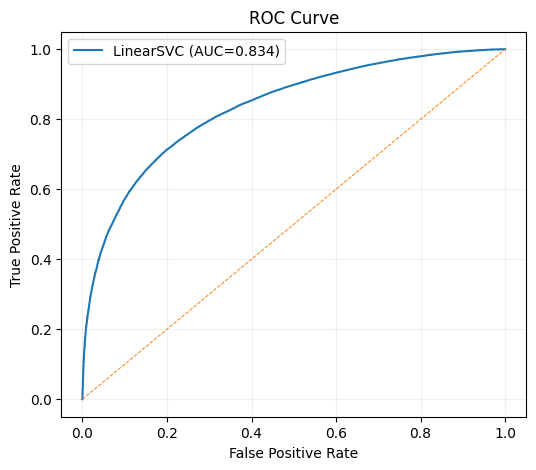

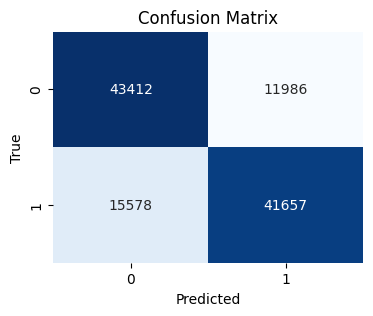

In [ ]:
# --- Predictions ---
y_test_pred = best_model.predict(X_test)
y_test_scores = best_model.decision_function(X_test) 

# --- Classification report ---
report = classification_report(y_test, y_test_pred, digits=4)
print("\nClassification report (test):")
print(report)

# --- Confusion matrix ---
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix:\n", cm)

# --- Summary statistics ---
test_f1 = f1_score(y_test, y_test_pred)
test_acc = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_scores)
print(f"Test Accuracy = {test_acc:.4f}")
print(f"Test F1-score = {test_f1:.4f}")
print(f"Test ROC-AUC = {test_auc:.4f}")

# --- ROC curve ---
fpr, tpr, _ = roc_curve(y_test, y_test_scores)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"LinearSVC (AUC={test_auc:.3f})")
plt.plot([0,1],[0,1],'--', linewidth=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# --- Confusion matrix heatmap ---
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
